0~9 까지 사람이 그린 손글씨 데이터인 MNIST를 활용해 10개의 클래스로 분류

MLP 모델 설계 순서
1. 모듈 임포트하기
2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
3. MNIST 데이터 다운로드
4. 데이터 확인
5. 데이터 확인
6. MLP(Multi Layer Perceptron) 모델 설계
7. Optimizer, Objective Function 설정
8. MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
9. 학습되는 과정 속에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의
10. MLP 학습을 실행하면서 train, test set의 Loss 및 Test set Accuracy 확인

In [1]:
# 1. Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 2. Deep Learning 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
# MNIST 데이터 다운로드
train_dataset = datasets.MNIST(root = "../data/MNIST", train = True, download = True, transform = transforms.ToTensor())  # - 1
test_dataset = datasets.MNIST(root = "../data/MNIST", train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)  # - 2
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

100.0%


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100.0%

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw




7.9%

100.0%


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100.0%

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



흔히 데이터를 외부에서 파이썬으로 불러와 이용
엑셀 파일로 데이터를 주고받을땐 Pandas Module을 이용해 pd.read_csv(), pd.read_excel() 함수를 이용

(1)
- root: 데이터가 저장될 장소
- train: 대상 데이터가 모델을 학습하기 위해 이용하는 학습용 데이터인지, 학습된 이후 성능을 검증하기 위한 검증용 데이터인지를 지정
- download: 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지를 지정
- transform: 데이터를 다운로드할때 이미지 데이터에 대한 기본적인 전처리를 동시에 진행
torch 모듈로 설계한 MLP의 Input으로 이용되기 때문에 ToTensor() 메서드를 이용해 tensor 형태로 변경

(2)
다운로드한 데이터셋을 Mini-Batch 단위로 분리해 지정
Mini-Batch 단위를 이용해 MLP모델을 학습시킬 것이므로 Mini-Batch 별로 데이터를 묶어 단위를 맞춤
- dataset: Mini-Batch 단위로 할당하고자 하는 데이터셋을 지정
- shuffle: 데이터의 순서를 섞고자 할 때 이용. MLP 모델이 학습을 진행할 때 Label 정보의 순서를 암기해 학습을 진행할 수 있음
그러므로 잘못된 방향으로 학습하는 것을 방지하기 위해 데이터 순서를 섞음

In [5]:
# 데이터 확인
# Download한 후 Mini-batch 단위로 할당한 데이터의 개수와 형태를 확인
for(X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', X_train.size(), 'type:', X_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor


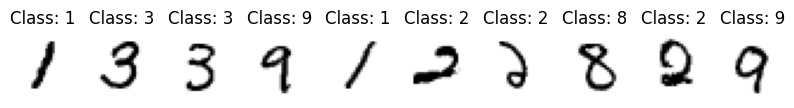

In [8]:
# 데이터 확인
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [9]:
# MLP(Multi Layer Perceptron) 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # - (1)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # - (2)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

(1): Fully Connected Layer를 정의, MNIST 데이터를 Input으로 사용하기 위해 28 * 28 * 1(가로 픽셀수 * 새로 픽셀수 * 채널수) 크기의 노드 수를 설정한 후
두번째 Fully Connected Layer의 노드 수를 512개로 설정할 것이기에 output의 노드 수는 512개로 설정

(2): MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음 
But, MNIST 이미지 데이터의 크기는 28 * 28인 2차원 데이터 따라서 2차원 데이터를 1차원 데이터로 변환하기 위해 View 메서드를 이용해 784 크기의 1차원 데이터로 변환해 진행 
이를 2차원의 데이터를 1차원으로 펼친다 하여 Flatten한다 라고 표현하기도 함

In [10]:
# Optimizer, Objective Function 설정
model = Net().to(DEVICE)  # - (1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)  # - (2)
criterion = nn.CrossEntropyLoss()  # - (3)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


(1): MLP 모델을 기존에 선정한 'DEVICE'에 할당
(2): Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의
이 예제에서는 Stochastic Gradient Descent(SGD) 알고리즘을 이용하여 파라미터를 업데이트할 때 learning rate을 0.01, Optimizer의 관성을 나타내는 momentum을 0.5로 설정
(3): MLP 모델의 output값과 계산될 Label 값은 Class를 표현하는 one-hot 인코딩 값
MLP 모델의 output 값과 one-hot encoding 값과의 Loss는 CrossEntropy를 이용해 계산

In [11]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):  # - (1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()  # - (2)
        output = model(image)  # - (3)
        loss = criterion(output, label)  # - (4)
        loss.backward()  # - (5)
        optimizer.step()  # - (6)

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100 * batch_idx / len(train_loader), loss.item()))

(1): 기존에 정의한 train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 Mini-Batch 단위로 묶여 저장
해당 train_loader 내에 Mini-Batch 단위로 저장된 데이터를 순서대로 이용해 학습
(2): 과거에 이용한 Mini-Batch 내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient 값이 optimizer에 할당돼 있으므로 optimizer의 Gradient를 초기화
(3): 장비에 할당한 이미지 데이터를 MLP 모델의 Input으로 이용해 Output을 계산
(4): 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss 값을 계산
(5): Loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당
(6): 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값을 업데이트

In [12]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수
def evaluate(model, test_loader):
    model.eval()  # - (1)
    test_loss = 0  # - (2)
    correct = 0  # - (3)

    with torch.no_grad():  # - (4)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()  # - (5)
            prediction = output.max(1, keepdim = True)[1]  # - (6)
            correct += prediction.eq(label.view_as(prediction)).sum().item()  # - (7)
    
    test_loss /= len(test_loader.dataset)  # - (8)
    test_accuracy = 100 * correct / len(test_loader.dataset)  # - (9)
    return test_loss, test_accuracy

(1): 학습 과정 또는 학습이 완료된 MLP 모델을 학습 상태가 아닌 평가 상태로 지정
(2): 기존에 정의한 test_loader 내의 데이터를 이용해 Loss값을 계산하기 위해 test_loss를 0으로 임시 설정
(3): 학습 과정 또는 학습이 완료된 MLP 모델이 올바른 Class로 분류한 경우를 세기 위해 correct = 0으로 임시 설정
(4): MLP 모델을 평가하는 단계에서 Gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용해 Gradient의 흐름을 억제
(5): 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss 값을 계산한 결괏값을 test_loss에 더해 업데이트
(6): MLP 모델의 Output 값은 크기가 10인 벡터 값인데 이 벡터값들 중 가장 큰값인 위치에 대해 해당 위치에 대응하는 클래스로 예측한걸로 판단
(7): MLP 모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
(8): 현재까지 계산된 test_loss의 값을 test_loader 내에 존재하는 Mini-Batch 개수만큼 나눠 평균 Loss 값으로 계산
(9): test_loader 데이터 중 얼마나 맞췄는지를 계산해 정확도를 계산

In [13]:
# MLP 학습을 실행하면서 Train, Test set의 Test set Accuracy를 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

/Users/hangyojeong/opt/anaconda3/envs/pytorch_test/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 2.299074
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 2.319171
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 2.350789
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 2.307976
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 2.280740
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 2.278879
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 2.312545
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 2.299366
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 2.242129
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 2.182324

 [EPOCH: 1], 	 Test Loss: 0.0695, 	 Test Accuracy: 19.36 %

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 2.209558
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 2.214949
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 2.139037
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 1.982741
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 2.001964
Train Epoch: 2 [32000/60000(53%)] 	 Train Loss: 1.817459
Train Epoch: 2 [38400/60000(64%)] 	 Tra